
# NVP Hypothesis - fixation scenarios
**Goal:** Examine fixation times of a neurogenesis-enhancing gene (ARHGAP11b-like) under different viral pressures.



## Viral fixation model



=== No BDV-like pressure (single mutation) ===
Replicates: 1000
Standing variation: False
Fixation probability: 0.000
Mean loss time (conditional on loss): 13 generations

=== No BDV-like pressure (standing, p0=0.01) ===
Replicates: 1000
Standing variation: True
Fixation probability: 0.400
Mean fixation time: 17038 generations
Median fixation time: 16936
Mean loss time (conditional on loss): 1077 generations

=== BDV-like pressure (single mutation, fluctuating q) ===
Replicates: 1000
Standing variation: False
Fixation probability: 0.006
Mean fixation time: 7092 generations
Median fixation time: 6960
Mean loss time (conditional on loss): 13 generations

=== BDV-like pressure (standing, p0=0.01) ===
Replicates: 1000
Standing variation: True
Fixation probability: 0.814
Mean fixation time: 7427 generations
Median fixation time: 7106
Mean loss time (conditional on loss): 614 generations


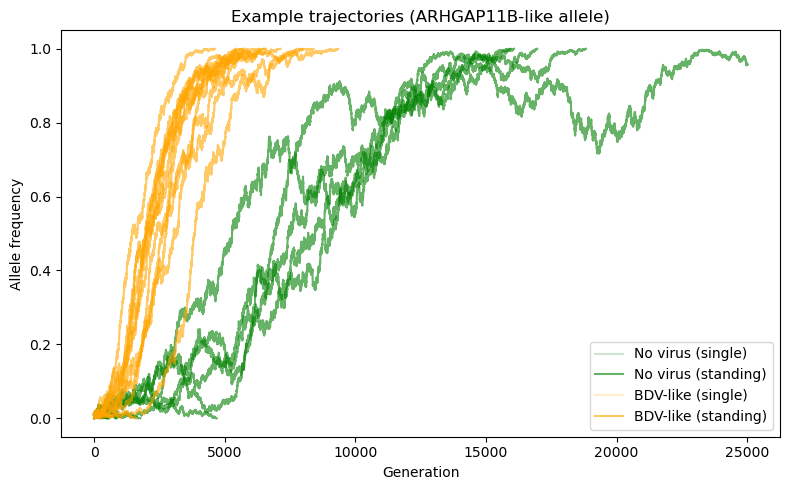

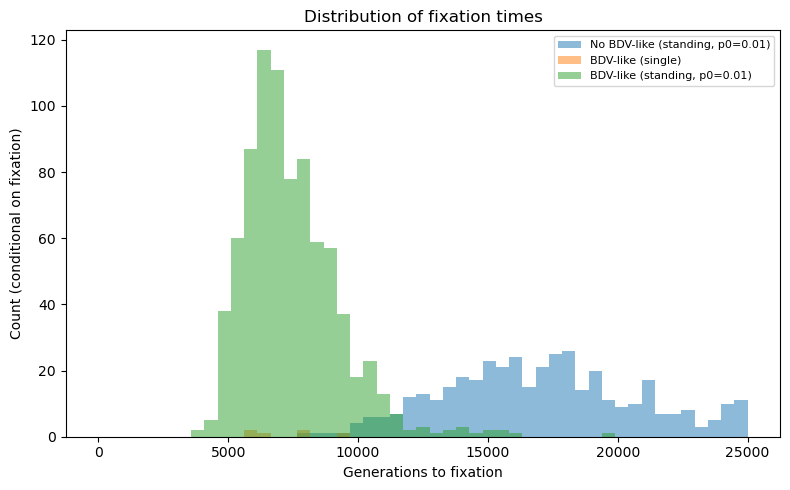

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# Parameters (feel free to tweak them)
# ============================================

Ne = 17_000               # effective population size (diploid)
max_gens = 25_000         # max generations to simulate
n_reps = 1000             # number of replicate simulations per scenario
n_traj_example = 15       # number of trajectories to plot for each scenario

# Selection components36
s_cog = 0.001            # baseline cognitive advantage (independent of virus)

# Virus environment parameters (for BDV-like scenario)
q_low   = 0            # baseline prevalence in "quiet" times
q_high  = 0.35           # prevalence during "epidemic" times
epidemic_prob = 1       # probability a given generation is in epidemic state
c_virus = 0.02          # fitness cost of infection in non-carriers
mitigated_damageAA = 0.70   # 0.70 means "30% cost averted".
mitigated_damageAa = 0.76    # 0.76 means "24% cost averted".

# Standing variation
p0_standing = 0.01       # initial allele frequency if starting from standing variation

rng = np.random.default_rng(42)

# ============================================
# Helper: draw q_t each generation (fluctuating virus environment)
# ============================================

def draw_q(q_low, q_high, epidemic_prob, rng):
    """
    Draw the virus prevalence q_t for a given generation.
    With probability epidemic_prob, use q_high (epidemic),
    otherwise use q_low (baseline).
    """
    if rng.random() < epidemic_prob:
        return q_high
    else:
        return q_low

# ============================================
# Wright–Fisher with diploid additive selection + virus environment
# ============================================

def simulate_wf_selection_bdv(
    Ne,
    s_cog,
    q_low,
    q_high,
    epidemic_prob,
    c_virus,
    max_gens,
    rng,
    standing=False
):
    """
    Simulate one trajectory of a beneficial allele in a diploid Wright–Fisher population.

    - Ne: effective population size
    - s_cog: baseline cognitive advantage
    - q_low, q_high, epidemic_prob, c_virus: virus environment parameters
    - max_gens: maximum number of generations to simulate
    - standing: if False, start from a single copy; if True, start from p0_standing

    Diploid additive fitness:
       w_aa = 1
       w_Aa = 1 + s_eff
       w_AA = 1 + 2 s_eff
    where s_eff = s_cog + q_t * c_virus for BDV-like scenario.
    """
    if standing:
        p = p0_standing
    else:
        p = 1.0 / (2.0 * Ne)

    traj = [p]

    for gen in range(1, max_gens + 1):
        if p <= 0.0:
            return None, gen, traj
        if p >= 1.0:
            return gen, None, traj

        # Draw current virus prevalence
        q_t = draw_q(q_low, q_high, epidemic_prob, rng)
        # Effective selection
        virus_penalty = q_t * c_virus

        # Diploid additive selection: w_aa = 1, w_Aa = 1 + s_eff, w_AA = 1 + 2*s_eff
        w_aa = 1.0 - virus_penalty
        w_Aa = 1.0 - virus_penalty * mitigated_damageAa + s_cog * 0.8
        w_AA = 1.0 - virus_penalty * mitigated_damageAA + s_cog
        q = 1.0 - p
        p2 = p * p
        pq = p * q

        wbar = p2 * w_AA + 2.0 * pq * w_Aa + q * q * w_aa
        # Post-selection allele frequency
        p_sel = (p2 * w_AA + pq * w_Aa) / wbar

        # Genetic drift
        X = rng.binomial(2 * Ne, p_sel)
        p = X / (2.0 * Ne)
        traj.append(p)

    # No fixation or loss within max_gens
    return None, None, traj

# ============================================
# Scenario runner
# ============================================

def run_scenario(
    Ne,
    s_cog,
    q_low,
    q_high,
    epidemic_prob,
    c_virus,
    max_gens,
    rng,
    label,
    standing=False
):
    fix_times = []
    loss_times = []
    example_trajs = []

    for i in range(n_reps):
        t_fix, t_loss, traj = simulate_wf_selection_bdv(
            Ne,
            s_cog,
            q_low,
            q_high,
            epidemic_prob,
            c_virus,
            max_gens,
            rng,
            standing=standing
        )
        if t_fix is not None:
            fix_times.append(t_fix)
        if t_loss is not None:
            loss_times.append(t_loss)
        if len(example_trajs) < n_traj_example:
            example_trajs.append(traj)

    return {
        "label": label,
        "fix_times": np.array(fix_times),
        "loss_times": np.array(loss_times),
        "example_trajs": example_trajs,
        "standing": standing,
    }

def summarize(res):
    label = res["label"]
    fix = res["fix_times"]
    loss = res["loss_times"]
    print(f"\n=== {label} ===")
    print(f"Replicates: {n_reps}")
    print(f"Standing variation: {res['standing']}")
    print(f"Fixation probability: {len(fix)/n_reps:.3f}")
    if len(fix) > 0:
        print(f"Mean fixation time: {fix.mean():.0f} generations")
        print(f"Median fixation time: {np.median(fix):.0f}")
    if len(loss) > 0:
        print(f"Mean loss time (conditional on loss): {loss.mean():.0f} generations")

# ============================================
# Run two scenarios:
#   1) No BDV-like pressure (q_low=q_high=0)
#   2) BDV-like pressure with fluctuating environment
#  toggle standing=True/False when needed
# ============================================

# Scenario 1: no BDV-like pressure, single mutation
res_no_virus_single = run_scenario(
    Ne=Ne,
    s_cog=s_cog,
    q_low=0.0,
    q_high=0.0,
    epidemic_prob=0.0,
    c_virus=0.0,
    max_gens=max_gens,
    rng=np.random.default_rng(123),
    label="No BDV-like pressure (single mutation)",
    standing=False 
)

# Scenario 1b: no BDV-like pressure, single mutation
res_no_virus_standing = run_scenario(
    Ne=Ne,
    s_cog=s_cog,
    q_low=0.0,
    q_high=0.0,
    epidemic_prob=0.0,
    c_virus=0.0,
    max_gens=max_gens,
    rng=np.random.default_rng(234),
    label=f"No BDV-like pressure (standing, p0={p0_standing})",
    standing=True
)

# Scenario 2: BDV-like pressure, fluctuating q, single mutation
res_virus_single = run_scenario(
    Ne=Ne,
    s_cog=s_cog,
    q_low=q_low,
    q_high=q_high,
    epidemic_prob=epidemic_prob,
    c_virus=c_virus,
    max_gens=max_gens,
    rng=np.random.default_rng(456),
    label="BDV-like pressure (single mutation, fluctuating q)",
    standing=False
)

# Scenario 2b: BDV-like pressure, standing variation
res_virus_standing = run_scenario(
    Ne=Ne,
    s_cog=s_cog,
    q_low=q_low,
    q_high=q_high,
    epidemic_prob=epidemic_prob,
    c_virus=c_virus,
    max_gens=max_gens,
    rng=np.random.default_rng(789),
    label=f"BDV-like pressure (standing, p0={p0_standing})",
    standing=True
)



# ============================================
# Summaries
# ============================================

summarize(res_no_virus_single)
summarize(res_no_virus_standing)
summarize(res_virus_single)
summarize(res_virus_standing)

# ============================================
# Plot example trajectories
# ============================================

colors = {
    "no_virus_single": "green",
    "no_virus_standing": "green",
    "virus_single": "orange",
    "virus_standing": "orange"
}


fig, ax = plt.subplots(figsize=(8, 5))

for traj in res_no_virus_single["example_trajs"]:
    ax.plot(traj, alpha=0.2, color=colors["no_virus_single"])

for traj in res_no_virus_standing["example_trajs"]:
    ax.plot(traj, alpha=0.6, color=colors["no_virus_standing"])

for traj in res_virus_single["example_trajs"]:
    ax.plot(traj, alpha=0.2, color=colors["virus_single"])

for traj in res_virus_standing["example_trajs"]:
    ax.plot(traj, alpha=0.6, color=colors["virus_standing"])

ax.set_xlabel("Generation")
ax.set_ylabel("Allele frequency")
ax.set_title("Example trajectories (ARHGAP11B-like allele)")
ax.plot([], [], color=colors["no_virus_single"], alpha=0.2, label="No virus (single)")
ax.plot([], [], color=colors["no_virus_standing"], alpha=0.6, label="No virus (standing)")
ax.plot([], [], color=colors["virus_single"], alpha=0.2, label="BDV-like (single)")
ax.plot([], [], color=colors["virus_standing"], alpha=0.6, label="BDV-like (standing)")
ax.legend()
plt.tight_layout()
plt.show()



# ============================================
# Plot fixation-time histograms (conditional on fixation)
# ============================================

fig, ax = plt.subplots(figsize=(8, 5))

bins = np.linspace(0, max_gens, 50)

for res, style in [
    (res_no_virus_single, dict(alpha=0.5, label="No BDV-like (single)")),
    (res_no_virus_standing,  dict(alpha=0.5, label=f"No BDV-like (standing, p0={p0_standing})")),
    (res_virus_single,    dict(alpha=0.5, label="BDV-like (single)")),
    (res_virus_standing,  dict(alpha=0.5, label=f"BDV-like (standing, p0={p0_standing})")),
]:
    if len(res["fix_times"]) > 0:
        ax.hist(res["fix_times"], bins=bins, **style)

ax.set_xlabel("Generations to fixation")
ax.set_ylabel("Count (conditional on fixation)")
ax.set_title("Distribution of fixation times")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()